In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("SP1_new.CSV")

# Konversi string ke format datetime
df["Time"] = pd.to_datetime(df["Time"].str.strip(), format="%H:%M:%S.%f")
start_time = df["Time"].iloc[0]
df["Time"] = (df["Time"] - start_time).dt.total_seconds()


# Hitung frekuensi sampling dari rata-rata selisih waktu
print(df["Time"].diff().describe())


df

count    1975.000000
mean        0.972834
std         0.440689
min         0.137000
25%         0.694500
50%         1.072000
75%         1.309000
max         7.738000
Name: Time, dtype: float64


,Time,Frequency Reference,Output Frequency,Output Current,Output Voltage,Output Power,DC Bus Voltage,Output Frequency After Soft-start,Peak Voltage Current,Regenerative Power (kWh),Power Supply Voltage,Power Supply Frequency,Electric Power (kWh),Cooling Fin Temperature,Peak Voltage Output Frequency,Motor q-Axis Current during Fault,Fin Temperature
0,0.000,48.18,48.18,82.05,371.1,42.7,588.0,48.18,199.8,0.0,399.0,50.0,938.0,36.0,2.23,-11.5,32.0
1,0.155,48.17,48.17,80.86,371.0,43.7,589.0,48.17,199.8,0.0,399.0,50.0,938.0,36.0,2.23,-11.5,32.0
2,0.297,48.16,48.16,82.14,370.9,40.8,590.0,48.14,199.8,0.0,400.0,50.0,938.0,36.0,2.23,-11.5,32.0
3,0.434,48.14,48.14,82.67,370.9,43.7,593.0,48.15,199.8,0.0,400.0,50.0,938.0,36.0,2.23,-11.5,32.0
4,0.572,48.17,48.17,86.77,371.1,45.7,586.0,48.16,199.8,0.0,399.0,50.0,938.0,36.0,2.23,-11.5,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,1915.752,48.17,48.17,82.27,371.2,45.9,585.0,48.17,199.8,0.0,397.0,50.0,962.0,37.0,2.23,-11.5,32.0
1972,1917.111,48.17,48.17,85.09,371.2,44.5,591.0,48.17,199.8,0.0,399.0,50.0,962.0,37.0,2.23,-11.5,32.0
1973,1918.540,48.16,48.16,86.99,371.3,45.8,590.0,48.16,199.8,0.0,398.0,49.9,962.0,37.0,2.23,-11.5,32.0
1974,1919.901,48.17,48.17,81.44,371.1,46.3,584.0,48.17,199.8,0.0,398.0,50.0,962.0,37.0,2.23,-11.5,32.0


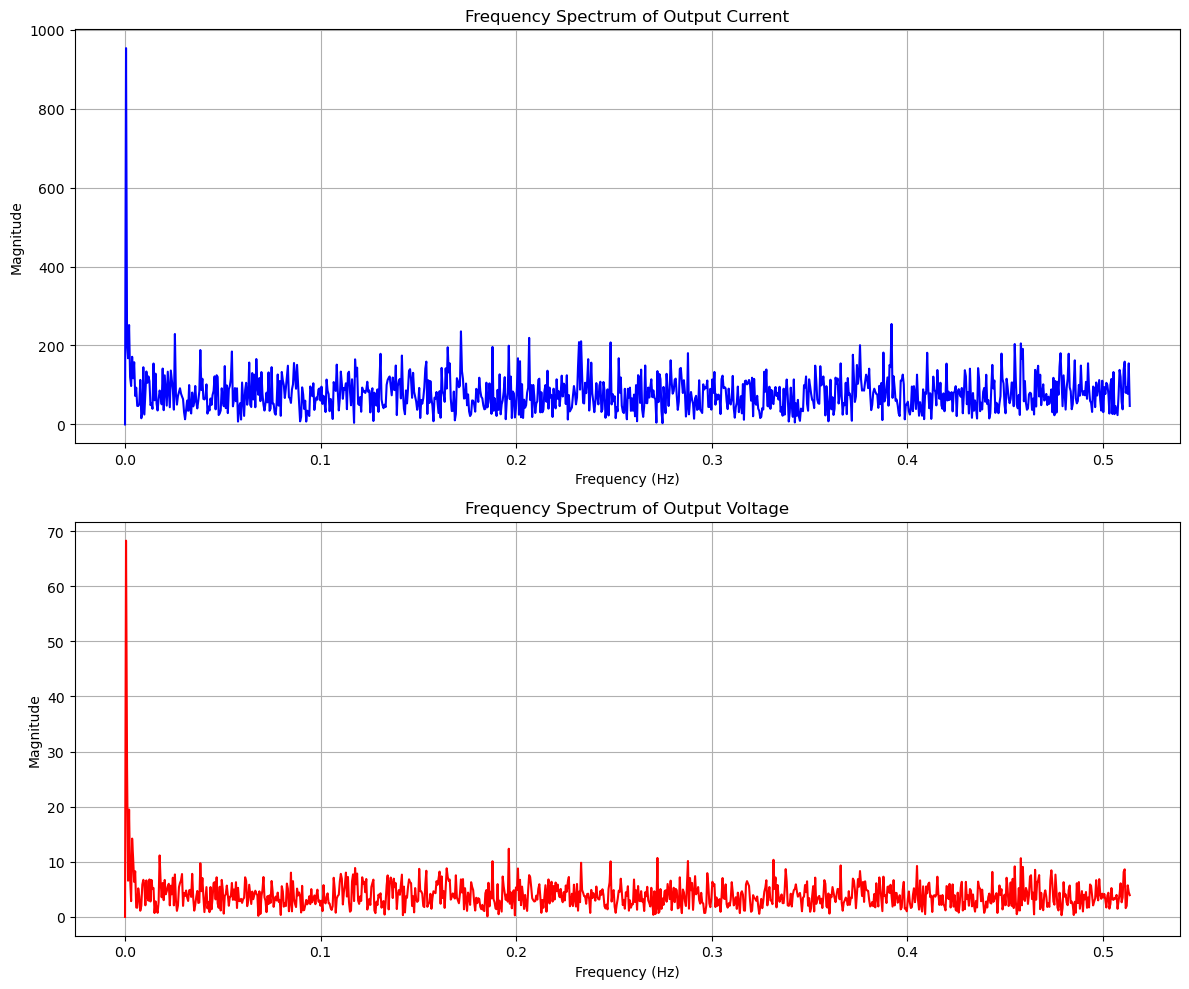

In [44]:
# FFT untuk Output Current
current_signal = df["Output Current"] - df["Output Current"].mean()
current_fft = np.fft.fft(current_signal)
current_freq = np.fft.fftfreq(len(current_fft), d=1/sampling_rate)

# FFT untuk Output Voltage
voltage_signal = df["Output Voltage"] - df["Output Voltage"].mean()
voltage_fft = np.fft.fft(voltage_signal)
voltage_freq = np.fft.fftfreq(len(voltage_fft), d=1/sampling_rate)

# Plot ulang FFT untuk arus dan tegangan
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Magnitudo FFT Output Current
axes[0].plot(current_freq[:len(current_freq)//2], np.abs(current_fft[:len(current_fft)//2]), color="blue")
axes[0].set_title("Frequency Spectrum of Output Current")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Magnitude")
axes[0].grid()

# Magnitudo FFT Output Voltage
axes[1].plot(voltage_freq[:len(voltage_freq)//2], np.abs(voltage_fft[:len(voltage_fft)//2]), color="red")
axes[1].set_title("Frequency Spectrum of Output Voltage")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Magnitude")
axes[1].grid()

plt.tight_layout()
plt.show()


In [45]:
# Fungsi untuk menghitung THD dengan pemilihan fundamental yang benar
def calculate_thd(signal_fft, freqs, max_harmonics=50):
    fundamental_idx = np.argmax(np.abs(signal_fft[1:len(signal_fft)//2])) + 1  # Hindari DC component
    fundamental = np.abs(signal_fft[fundamental_idx])
    
    harmonics = np.abs(signal_fft[fundamental_idx+1:fundamental_idx+max_harmonics])  # Batasi harmonisa
    
    thd = np.sqrt(np.sum(harmonics ** 2)) / fundamental * 100  # THD dalam persen
    return thd

# Menghitung THD untuk Output Current dan Output Voltage
thd_current = calculate_thd(current_fft, current_freq)
thd_voltage = calculate_thd(voltage_fft, voltage_freq)

# Tampilkan hasil
thd_current, thd_voltage


(80.56332914441637, 74.70607145551185)

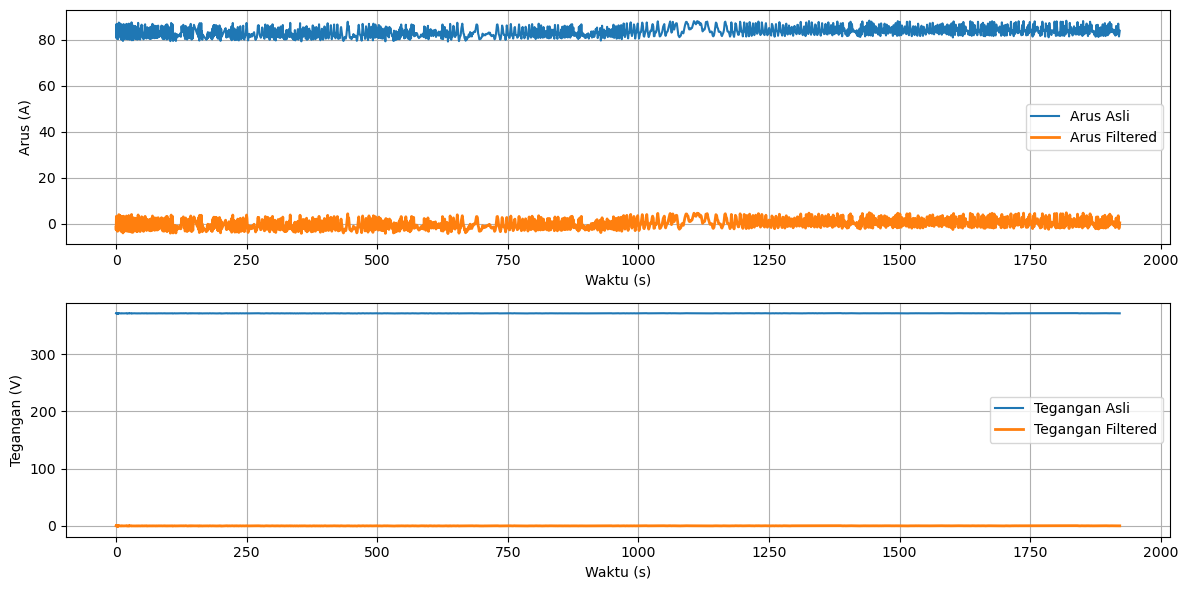

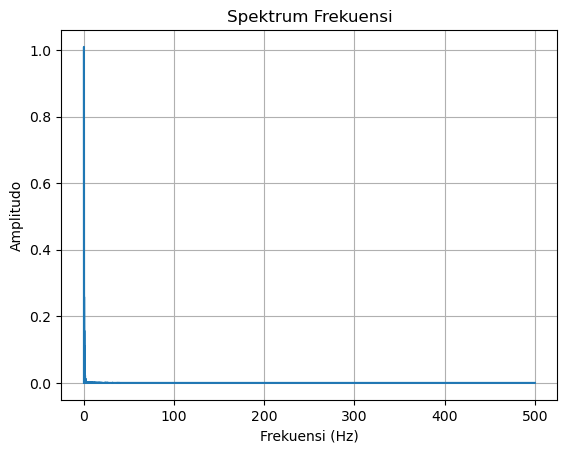

Frekuensi Fundamental Terdeteksi: 0.00 Hz
Frekuensi fundamental terdeteksi (0.00 Hz) tidak sesuai dengan frekuensi sistem (50 Hz).
THD Arus: 29621.75%


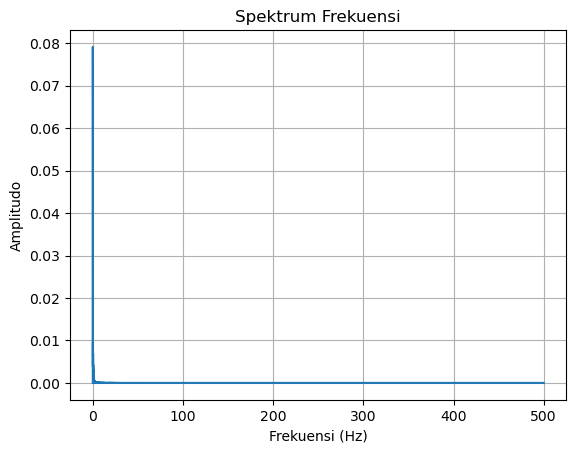

Frekuensi Fundamental Terdeteksi: 0.00 Hz
Frekuensi fundamental terdeteksi (0.00 Hz) tidak sesuai dengan frekuensi sistem (50 Hz).
THD Tegangan: 52657.24%


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

# Membaca file CSV
file_path = 'SP1_new.CSV'  # Ganti dengan path file CSV Anda
df = pd.read_csv(file_path)  # Skip header yang tidak diperlukan

# Konversi string ke format datetime
df["Time"] = pd.to_datetime(df["Time"].str.strip(), format="%H:%M:%S.%f")
start_time = df["Time"].iloc[0]
df["Time"] = (df["Time"] - start_time).dt.total_seconds()

# Ekstrak kolom waktu, arus, dan tegangan
time = df['Time'].values  # Kolom waktu (tidak konstan)
output_current = df['Output Current'].values  # Kolom arus
output_voltage = df['Output Voltage'].values  # Kolom tegangan

# Interpolasi data ke grid waktu yang seragam
def resample_to_uniform_time(time, signal, new_sampling_rate=1000):
    new_time = np.linspace(time[0], time[-1], int((time[-1] - time[0]) * new_sampling_rate))
    interpolator = interp1d(time, signal, kind='linear', fill_value="extrapolate")
    new_signal = interpolator(new_time)
    return new_time, new_signal

# Resample data ke grid waktu seragam
new_sampling_rate = 1000  # Sampling rate baru (Hz)
new_time, resampled_current = resample_to_uniform_time(time, output_current, new_sampling_rate)
_, resampled_voltage = resample_to_uniform_time(time, output_voltage, new_sampling_rate)

# Fungsi untuk membuat filter low-pass
def butter_lowpass_filter(data, cutoff_freq, sampling_rate, order=5):
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Filter sinyal arus dan tegangan
cutoff_freq = 100  # Frekuensi cutoff untuk filter low-pass (Hz)
filtered_current = butter_lowpass_filter(resampled_current, cutoff_freq, new_sampling_rate)
filtered_voltage = butter_lowpass_filter(resampled_voltage, cutoff_freq, new_sampling_rate)

# Hilangkan komponen DC
filtered_current = filtered_current - np.mean(filtered_current)
filtered_voltage = filtered_voltage - np.mean(filtered_voltage)

# Plot sinyal setelah resampling dan filtering
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(new_time, resampled_current, label='Arus Asli')
plt.plot(new_time, filtered_current, label='Arus Filtered', linewidth=2)
plt.xlabel('Waktu (s)')
plt.ylabel('Arus (A)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(new_time, resampled_voltage, label='Tegangan Asli')
plt.plot(new_time, filtered_voltage, label='Tegangan Filtered', linewidth=2)
plt.xlabel('Waktu (s)')
plt.ylabel('Tegangan (V)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Fungsi untuk menghitung FFT dan THD
def calculate_thd(signal, sampling_rate, fundamental_freq=50):
    N = len(signal)
    T = 1 / sampling_rate
    yf = fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

    # Plot spektrum frekuensi
    plt.figure()
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.title('Spektrum Frekuensi')
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Amplitudo')
    plt.grid()
    plt.show()

    # Cari frekuensi fundamental
    fundamental_index = np.argmax(2.0/N * np.abs(yf[:N//2]))
    fundamental_freq_detected = xf[fundamental_index]
    print(f'Frekuensi Fundamental Terdeteksi: {fundamental_freq_detected:.2f} Hz')

    # Jika frekuensi fundamental tidak sesuai, gunakan frekuensi sistem yang diharapkan
    if not np.isclose(fundamental_freq_detected, fundamental_freq, atol=1):
        print(f'Frekuensi fundamental terdeteksi ({fundamental_freq_detected:.2f} Hz) tidak sesuai dengan frekuensi sistem ({fundamental_freq} Hz).')
        fundamental_index = np.where(np.isclose(xf, fundamental_freq, atol=1))[0][0]
        fundamental_freq_detected = fundamental_freq

    # Hitung THD
    fundamental = 2.0/N * np.abs(yf[fundamental_index])
    harmonics = 2.0/N * np.abs(yf[np.where((xf > fundamental_freq_detected) & (xf <= 250))])
    thd = np.sqrt(np.sum(harmonics**2)) / fundamental * 100
    return thd

# Analisis harmonisa untuk arus
thd_current = calculate_thd(filtered_current, new_sampling_rate)
print(f'THD Arus: {thd_current:.2f}%')

# Analisis harmonisa untuk tegangan
thd_voltage = calculate_thd(filtered_voltage, new_sampling_rate)
print(f'THD Tegangan: {thd_voltage:.2f}%')